In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from scipy import stats
from tabulate import tabulate

# Set plotting style
rc={'ytick.labelsize': 14}
sns.set(rc=rc)
plt.style.use('seaborn-white')
sns.set_palette(sns.husl_palette(7))

%matplotlib inline

In [2]:
# Date conversion function
def date_columns(query):
    """If a date column is included in the query, parse it as a date in the
    dataframe."""
    dates = []
    fields = ["Collision_Date", "Process_Date"]
    if '*' in query:
        dates = fields
    else:
        for date in fields:
            if date in query:
                dates.append(date)

        if not dates:
            dates = None

    return dates

In [3]:
# Database query runner
def run_query(query, sql_file="./20180925_switrs.sqlite3"):
    """ Read sqlite query results into a pandas DataFrame. """
    with sqlite3.connect(sql_file) as con:
        # Construct a Dataframe from the results
        df = pd.read_sql_query(
            query,
            con,
            parse_dates = date_columns(query),
        )

        return df

# Crashes after the DST change

In [4]:
# Select the dates where DST started in California, and select a week before and two weeks after

FORMAT = "%Y-%m-%d"

DATES = [
    dt.datetime.strptime("2001-04-01", FORMAT),
    dt.datetime.strptime("2002-04-07", FORMAT),
    dt.datetime.strptime("2003-04-06", FORMAT),
    dt.datetime.strptime("2004-04-04", FORMAT),
    dt.datetime.strptime("2005-04-03", FORMAT),
    dt.datetime.strptime("2006-04-02", FORMAT),
    dt.datetime.strptime("2007-03-11", FORMAT),
    dt.datetime.strptime("2008-03-09", FORMAT),
    dt.datetime.strptime("2009-03-08", FORMAT),
    dt.datetime.strptime("2010-03-14", FORMAT),
    dt.datetime.strptime("2011-03-13", FORMAT),
    dt.datetime.strptime("2012-03-11", FORMAT),
    dt.datetime.strptime("2013-03-10", FORMAT),
    dt.datetime.strptime("2014-03-09", FORMAT),
    dt.datetime.strptime("2015-03-08", FORMAT),
    dt.datetime.strptime("2016-03-13", FORMAT),
    #dt.datetime.strptime("2017-03-12", FORMAT),
]

BEFORE_DATE = []
for date in DATES:
    week_before = date - dt.timedelta(weeks=1)
    four_weeks_after = date + dt.timedelta(days=7*6)
    BEFORE_DATE.append((week_before.strftime(FORMAT), four_weeks_after.strftime(FORMAT)))

In [5]:
query = (
    "SELECT Collision_Date "
    "FROM Collision AS C "
    "WHERE Collision_Date IS NOT NULL "
    "AND ( "
)

for start, end in BEFORE_DATE:
    query += "(Collision_Date BETWEEN '{start}' AND '{end}') OR ".format(start=start, end=end)

query = query[:-4] + ")"

df = run_query(query)

In [6]:
CRASH_COL = "Crashes"
DATE_COL = "Collision_Date"

df[CRASH_COL] = 1

df = df.groupby(DATE_COL).sum()
df = df.reset_index()  # Return the Collision_Date Column

# Add additional information about that dates
df["DOW"]     = df[DATE_COL].dt.dayofweek
df["Year"]    = df[DATE_COL].dt.year

In [7]:
def date_delta(row):
    test_date = row['Collision_Date']
    delta = int(dt.timedelta(weeks=100).days)
    min_date = None
    for time in DATES:
        d = int((test_date - time).days)
        if abs(d) < abs(delta):
            delta = d
            min_date = time
        if abs(delta) < 10:  # We've found it!
            break

    return delta

In [8]:
def week_delta(row):
    days = row['Days_Since_DST']
    return days // 7

In [9]:
df['Days_Since_DST'] = df.apply(date_delta, axis=1)
df['Weeks_Since_DST'] = df.apply(week_delta, axis=1)

In [10]:
# Join the dataframe to itself so we can compute the crash ratio

joined_df = df.merge(df, on=["Year", "DOW"], how="left")

# _x variables will always be DST week, _y will be others
pruned_joined_df = joined_df[joined_df["Weeks_Since_DST_x"] == 0]
pruned_joined_df = pruned_joined_df[pruned_joined_df["Weeks_Since_DST_y"] != 0]

two_vs_three_df = joined_df[joined_df["Weeks_Since_DST_x"] == 2]
two_vs_three_df = two_vs_three_df[two_vs_three_df["Weeks_Since_DST_y"] == 3]

one_vs_three_df = joined_df[joined_df["Weeks_Since_DST_x"] == 1]
one_vs_three_df = one_vs_three_df[one_vs_three_df["Weeks_Since_DST_y"] == 3]

In [11]:
# Compute the crash ratio for the week after DST, and the week before DST

after_df = pruned_joined_df[pruned_joined_df["Weeks_Since_DST_y"] == 1].copy(deep=True)
double_after_df = pruned_joined_df[pruned_joined_df["Weeks_Since_DST_y"] == 2].copy(deep=True)
before_df = pruned_joined_df[pruned_joined_df["Weeks_Since_DST_y"] == -1].copy(deep=True)

after_df["Ratio"] = after_df["Crashes_x"] / after_df["Crashes_y"]
before_df["Ratio"] = before_df["Crashes_x"] / before_df["Crashes_y"]
double_after_df["Ratio"] =  double_after_df["Crashes_x"] / double_after_df["Crashes_y"]
two_vs_three_df["Ratio"] = two_vs_three_df["Crashes_x"] / two_vs_three_df["Crashes_y"]
one_vs_three_df["Ratio"] = one_vs_three_df["Crashes_x"] / one_vs_three_df["Crashes_y"]

In [12]:
after_df = after_df[["Collision_Date_x", "Year", "DOW", "Ratio", "Days_Since_DST_x"]]
before_df = before_df[["Collision_Date_x", "Year", "DOW", "Ratio", "Days_Since_DST_x"]]
double_after_df = double_after_df[["Collision_Date_x", "Year", "DOW", "Ratio", "Days_Since_DST_x"]]
two_vs_three_df = two_vs_three_df[["Collision_Date_x", "Year", "DOW", "Ratio", "Days_Since_DST_x"]]
one_vs_three_df = one_vs_three_df[["Collision_Date_x", "Year", "DOW", "Ratio", "Days_Since_DST_x"]]

In [13]:
# Normalize column names
new_names = {
    "Collision_Date_x": "Collision_Date", 
    "Days_Since_DST_x": "Days_Since_DST",
    "Collision_Date_y": "Collision_Date", 
    "Days_Since_DST_y": "Days_Since_DST",
}

after_df = after_df.rename(columns=new_names)
before_df = before_df.rename(columns=new_names)
double_after_df = double_after_df.rename(columns=new_names)

after_df = after_df.set_index("Collision_Date")
before_df = before_df.set_index("Collision_Date")
double_after_df = double_after_df.set_index("Collision_Date")

In [14]:
def make_violin_plot(df, label):
    day_order = [6, 0, 1, 2, 3, 4, 5]  # Put Sunday first because that is when the time changes
    
    ax = sns.violinplot(
        x="DOW",
        y="Ratio",
        data=df,
        order=day_order,
        linewidth=2,
        cut=1,
        inner="box",
    )
    ax.set_xlabel("DOW")
    ax.set_xticklabels(["Sunday (DST)", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], size=14)
    
    plt.title('Accidents after the start of DST in California (2001–2016)', y=1.03, size=26)
    FONTSIZE="xx-large"
    plt.xlabel("")
    plt.ylabel("Accident Ratio: DST Week / {label}".format(label=label), fontsize=FONTSIZE)
    
    plt.ylim(0.55, 1.7)
    
    return ax

/home/agude/bin/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


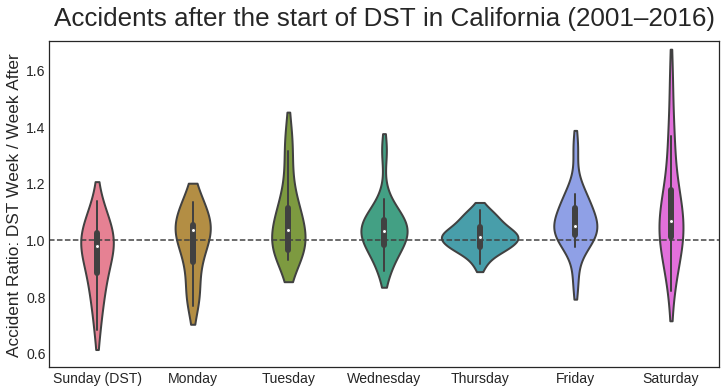

In [15]:
plt.figure(figsize=(12, 6))

# Plot the "No Change" Line
plt.axhline(y=1, linewidth=1.5, color="0.25", linestyle="dashed")

ax = make_violin_plot(after_df, "Week After")

for ext in ("png", "svg"):
    plt.savefig("/tmp/accidents_after_dst_change_in_california.{ext}".format(ext=ext), bbox_inches="tight")
    
plt.show()

/home/agude/bin/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


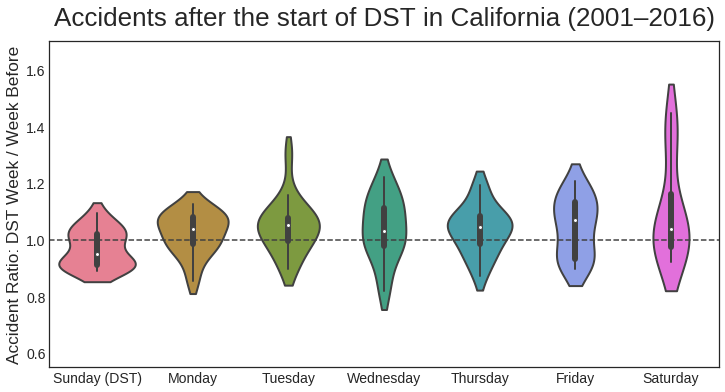

In [16]:
plt.figure(figsize=(12, 6))

# Plot the "No Change" Line
plt.axhline(y=1, linewidth=1.5, color="0.25", linestyle="dashed")

ax = make_violin_plot(before_df, "Week Before")

for ext in ("png", "svg"):
    plt.savefig("/tmp/accidents_after_dst_change_in_california_before.{ext}".format(ext=ext), bbox_inches="tight")
    
plt.show()

/home/agude/bin/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


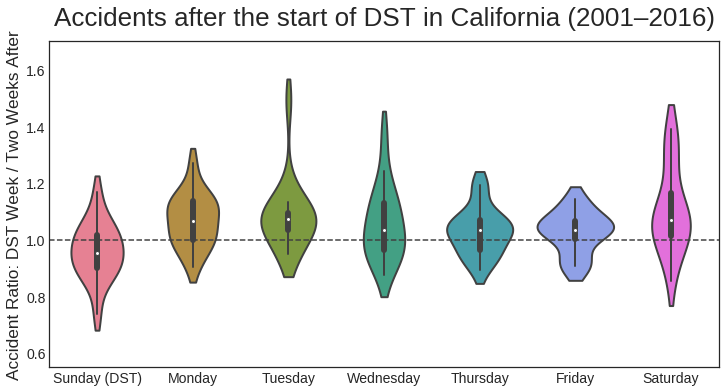

In [17]:
plt.figure(figsize=(12, 6))

# Plot the "No Change" Line
plt.axhline(y=1, linewidth=1.5, color="0.25", linestyle="dashed")

ax = make_violin_plot(double_after_df, "Two Weeks After")

for ext in ("png", "svg"):
    plt.savefig("/tmp/accidents_two_weeks_after_dst_change_in_california.{ext}".format(ext=ext), bbox_inches="tight")
    
plt.show()

/home/agude/bin/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


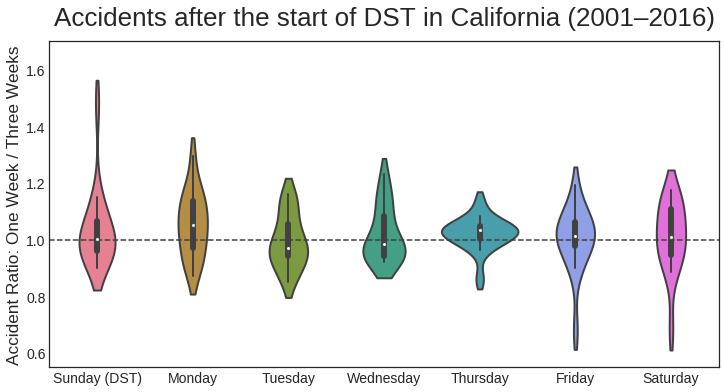

In [18]:
plt.figure(figsize=(12, 6))

# Plot the "No Change" Line
plt.axhline(y=1, linewidth=1.5, color="0.25", linestyle="dashed")

ax = make_violin_plot(one_vs_three_df, "")
plt.ylabel("Accident Ratio: One Week / Three Weeks", fontsize="xx-large")

for ext in ("png", "svg"):
    plt.savefig("/tmp/accidents_one_and_three_weeks_after_dst_change_in_california.{ext}".format(ext=ext), bbox_inches="tight")
    
plt.show()

/home/agude/bin/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


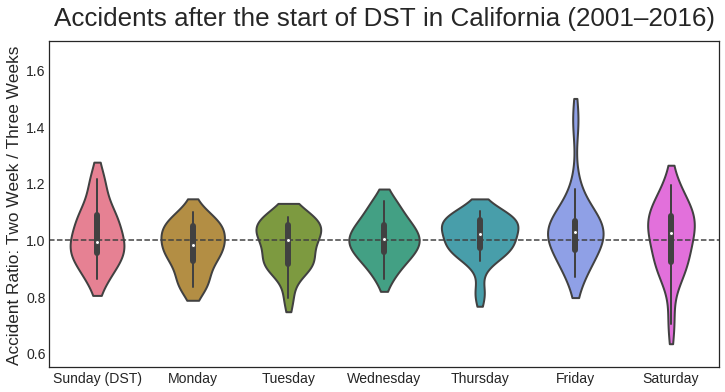

In [19]:
plt.figure(figsize=(12, 6))

# Plot the "No Change" Line
plt.axhline(y=1, linewidth=1.5, color="0.25", linestyle="dashed")

ax = make_violin_plot(two_vs_three_df, "")
plt.ylabel("Accident Ratio: Two Week / Three Weeks", fontsize="xx-large")

for ext in ("png", "svg"):
    plt.savefig("/tmp/accidents_two_and_three_weeks_after_dst_change_in_california.{ext}".format(ext=ext), bbox_inches="tight")
    
plt.show()

In [20]:
days = (
    "**Monday**",
    "**Tuesday**",
    "Wednesday",
    "Thursday",
    "Friday",
    "**Saturday**",
    "Sunday (DST)",
)

results = []
for dow, day in enumerate(days):
    sunday_df = joined_df[joined_df["DOW"]==dow]

    crashes_before = sunday_df[(sunday_df["Weeks_Since_DST_y"]==-1) & (sunday_df["Weeks_Since_DST_x"]==0)]["Crashes_y"].values
    crashes_after = sunday_df[(sunday_df["Weeks_Since_DST_y"]==1) & (sunday_df["Weeks_Since_DST_x"]==0)]["Crashes_y"].values
    crashes_double_after = sunday_df[(sunday_df["Weeks_Since_DST_y"]==2) & (sunday_df["Weeks_Since_DST_x"]==0)]["Crashes_y"].values
    crashes_same = sunday_df[(sunday_df["Weeks_Since_DST_y"]==2) & (sunday_df["Weeks_Since_DST_x"]==0)]["Crashes_x"].values

    crashes_mean = np.mean([crashes_before, crashes_after], axis=0)
    
    t_p = stats.ttest_rel(crashes_same, crashes_double_after)
    results.append((day, t_p[0], t_p[1]))

In [21]:
print(tabulate(results, ["Day", "_t_-value", "_p_-value"], "pipe", floatfmt="0.3f"))

| Day          |   _t_-value |   _p_-value |
|:-------------|------------:|------------:|
| **Monday**   |       2.693 |       0.017 |
| **Tuesday**  |       2.535 |       0.023 |
| Wednesday    |       1.641 |       0.122 |
| Thursday     |       1.369 |       0.191 |
| Friday       |       0.943 |       0.361 |
| **Saturday** |       2.622 |       0.019 |
| Sunday (DST) |      -1.646 |       0.121 |
